In [1]:
# import math functions
from math import sqrt, exp as mexp

# import numpy functions
from numpy import (
    vectorize, linspace, logspace, arange, zeros, log10, fill_diagonal, 
    exp, pi, set_printoptions, log2, inf, array, ndarray, diagonal,
    cos, sqrt as nsqrt, log
)
from numpy.linalg import solve, norm, inv, eigvals


import sys

# set to print lines to large width
set_printoptions(linewidth=500)

from itertools import cycle

%matplotlib inline
from matplotlib.style import use
use("seaborn")

# import the default plot settings
from pltconfig import *

# Problem 2

## Part D

In [48]:
class q2d(object):
    
    def __init__(self, a=0.0, b=1.0, m=50, alpha=0.0, beta=0.0):
        self.a = a
        self.b = b
        self.m = m
        self.alpha = alpha
        self.beta = beta
        self.dz = (b-a)/(m+1) # step size
        self.zpts = a + (arange(m+2))*self.dz
        self.xpts = self.a + (self.b-self.a)*0.5*(1 + cos(pi*(1-self.zpts)))
#         self.xpts = self.zpts
        self.hs = self.xpts[1:] - self.xpts[:-1]
        self.A = self.construct_A()
        self.F = self.construct_F()
        self.U = self.get_U()
    
    def get_all_parameters (self):
        return self.a, self.b, self.m, self.h, self.xpts
    
    def construct_A(self):
        
        m = self.m
        h = self.hs
        
        A = zeros((m+2,m+2))
        for i in range(1,m+1):
            for j in range(1,m+1):
                
                if (j==i+1):
                    A[i,j] = 2.0/(h[j]*(h[j]+h[j-1]))
                elif (j==i-1):
                    A[i,j] = 2.0/(h[j-1]*(h[j]+h[j-1]))
                elif (j == i):
                    A[i,j] = -2.0/(h[j]*h[j-1])
                else:
                    A[i,j] = 0.0
                                 
        A[0,0] = 1.0/h[0]; A[1,0] = 2.0/(h[0]*(h[0]+h[1]))
        A[-1,-1] = 1.0/h[-1]; A[-2,-1] = 2.0/(h[-1]*(h[-1]+h[-2]))         
        
        return A
    
    def get_Ainv(self):
        
        A = self.construct_A()
        
        return inv(A)
    
    def construct_F(self):
        
        # get parameters
        m = self.m
        xpts = self.xpts
                                
        # initialize the right-hand side
        F = zeros(m+2)
                                 
        # define the RHS in the interior of the domain
        F[1:-1] = cos(pi*xpts[1:-1])
        # define the LHS and RHS boundary terms, respectively
        F[0] = 0.0; F[-1] = 0.0
        
        return F
    
    def get_U(self):  
        return solve(self.A,self.F)
    
    def get_plot(self):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        
        ax.plot(self.xpts, -(1./(pi**2))*(2*self.xpts+cos(pi*self.xpts)-1), label="Exact")
        ax.plot(self.xpts, self.U, "o--", lw=3.0, label="Approx.")
        
        ax.legend(loc=0, prop={"size": 24})
        ax.set_ylabel(r"$U[x]$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig("q2d_sample_fig.pdf")

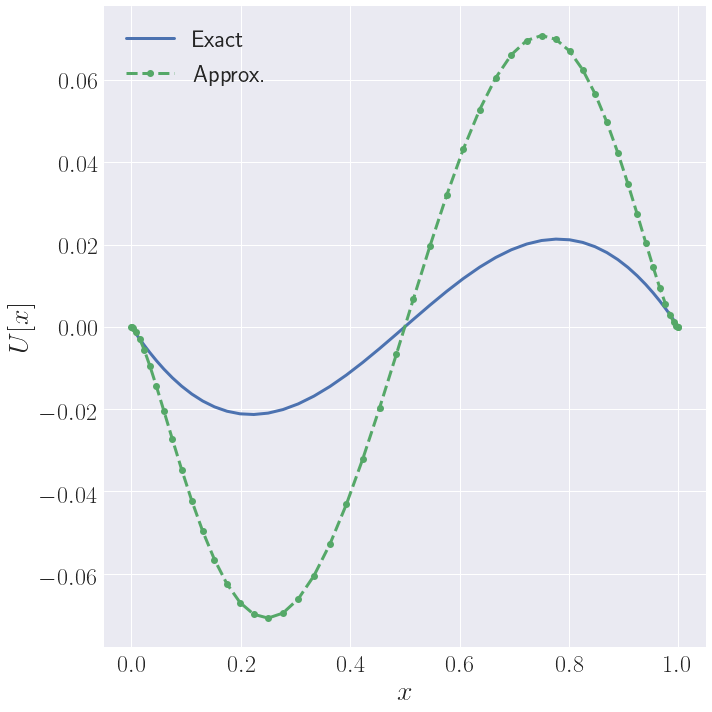

In [49]:
sample_2d = q2d()
sample_2d.get_plot()

In [50]:
def q2d_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        hvals = zeros(n)
        error_array1_2norm = zeros(n)
        error_array2_2norm = zeros(n)
        error_array1_infnorm = zeros(n)
        error_array2_infnorm = zeros(n)

        # set the number of initial number of internal points
        m_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q2d(m=m_coarse)

        print(f"m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)")
        
        for i in range(n):

            # define the finer grids
            m_fine = 2*m_coarse + 1

            # construct the meshes and solve 
            soln_fine = q2d(m=m_fine)

            # compute the errors using the grid-2norm
            error_array1_2norm[i] = sqrt(soln_coarse.dz)*norm(soln_coarse.U-soln_fine.U[::2], ord=2)

            # compute the errors using the infinity-norm
            error_array1_infnorm[i] = norm(soln_coarse.U-soln_fine.U[::2], ord=inf)

            # record the spacing
            hvals[i] = soln_coarse.dz

            # set the current fine grid as the coarse grid for next iteration
            m_coarse = m_fine 
            soln_coarse = soln_fine
            
            if (i > 0):
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    + f"{error_array1_2norm[i]/error_array1_2norm[i-1]:<16.5f}"
                    + f"{error_array1_infnorm[i]/error_array1_infnorm[i-1]:<18.5f}"
                    + f"{-log((error_array1_2norm[i]/error_array1_2norm[i-1]).__abs__())/log(2):<16.5f}"
                    + f"{-log((error_array1_infnorm[i]/error_array1_infnorm[i-1]).__abs__())/log(2):<16.5f}"
                    )
            else:
                print(
                    f"{m_coarse:<5d}"
                    + f"{hvals[i]:<9.5f}"
                    + f"{error_array1_2norm[i]:<14.2e}"
                    + f"{error_array1_infnorm[i]:<16.2e}"
                    )

        return hvals, error_array1_2norm, error_array1_infnorm

In [53]:
def plot_2d():
    
    hvals, error_array1_2norm, error_array1_infnorm = q2d_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(hvals, error_array1_2norm, lw=3.0, label="2-norm")
    ax.loglog(hvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(hvals, 10*hvals**2, lw=3.0, ls="--", color="gray", label=r"reference $(\Delta z)^{2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(\Delta z)$", fontsize=28)
    ax.set_xlabel(r"$\Delta z$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q2d_fig.pdf")

m    h        2-norm error  inf-norm error  ratio (2-norm)  ratio (inf-norm)  order (2-norm)  order (inf-norm)
9    0.20000  9.15e-03      1.04e-02        
19   0.10000  5.14e-03      7.98e-03        0.56152         0.76470           0.83258         0.38704         
39   0.05000  3.23e-03      5.05e-03        0.62930         0.63301           0.66819         0.65969         
79   0.02500  2.30e-03      3.62e-03        0.71007         0.71590           0.49397         0.48216         
159  0.01250  1.76e-03      2.79e-03        0.76668         0.77065           0.38331         0.37585         
319  0.00625  1.41e-03      2.24e-03        0.80119         0.80211           0.31979         0.31812         
639  0.00313  1.16e-03      1.84e-03        0.82327         0.82368           0.28056         0.27984         
1279 0.00156  9.75e-04      1.55e-03        0.83911         0.83920           0.25307         0.25291         
2559 0.00078  8.30e-04      1.32e-03        0.85159         0.85164

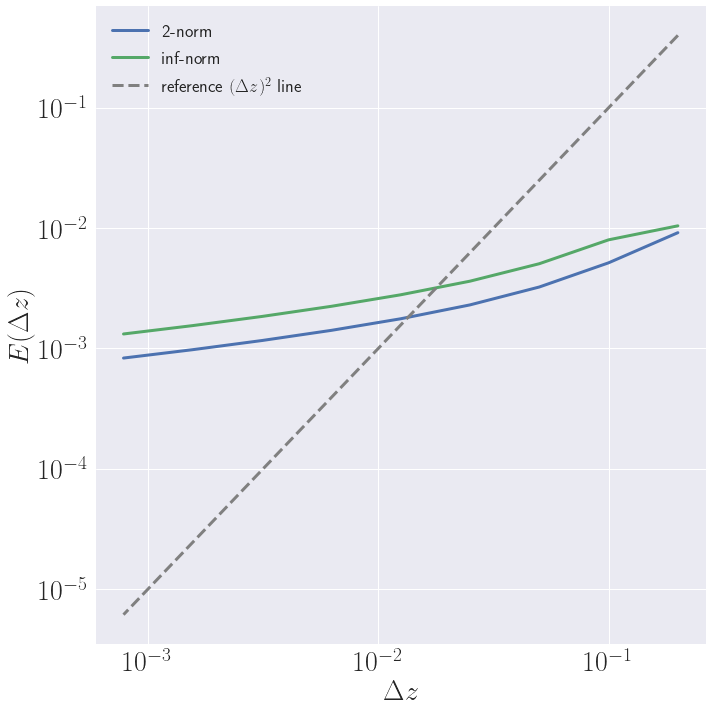

In [54]:
plot_2d()